# Heat equation - Retrieving operator through ODE solving

In [30]:
using Flux
using DiffEqFlux
using OrdinaryDiffEq

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")

Main.Generator

## Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

### Different methods

We make usage of different method to evaluate a solution to the heat equation. Starting from the well-known analytical solution to the equation $u(x,t) = \sum^{\inf}_{n=1} c_n e^{-\pi^2 n^2 t} sin(n \pi x)$,
we implemented as well different methods to study their efficiency with regards to the stability of the equation (explicit, implicit finite-difference, finite-element, pseudo-spectral)

While for testing the quality of our implementation we started with the analytical solution, in the case of heat equation it is interesting to continue with a pseudo-spectral form using FFRT, a numerically stable solution for a large range of parameters.

In [4]:
t_max = 1.0;
t_min = 0.01;
x_max = 1.;
x_min = 0.;
t_n = 64;
x_n = 64;

d = 0.1;
k = 1.;
c = [0.7, 0.3, 0.4];
n = [3, 7, 10];

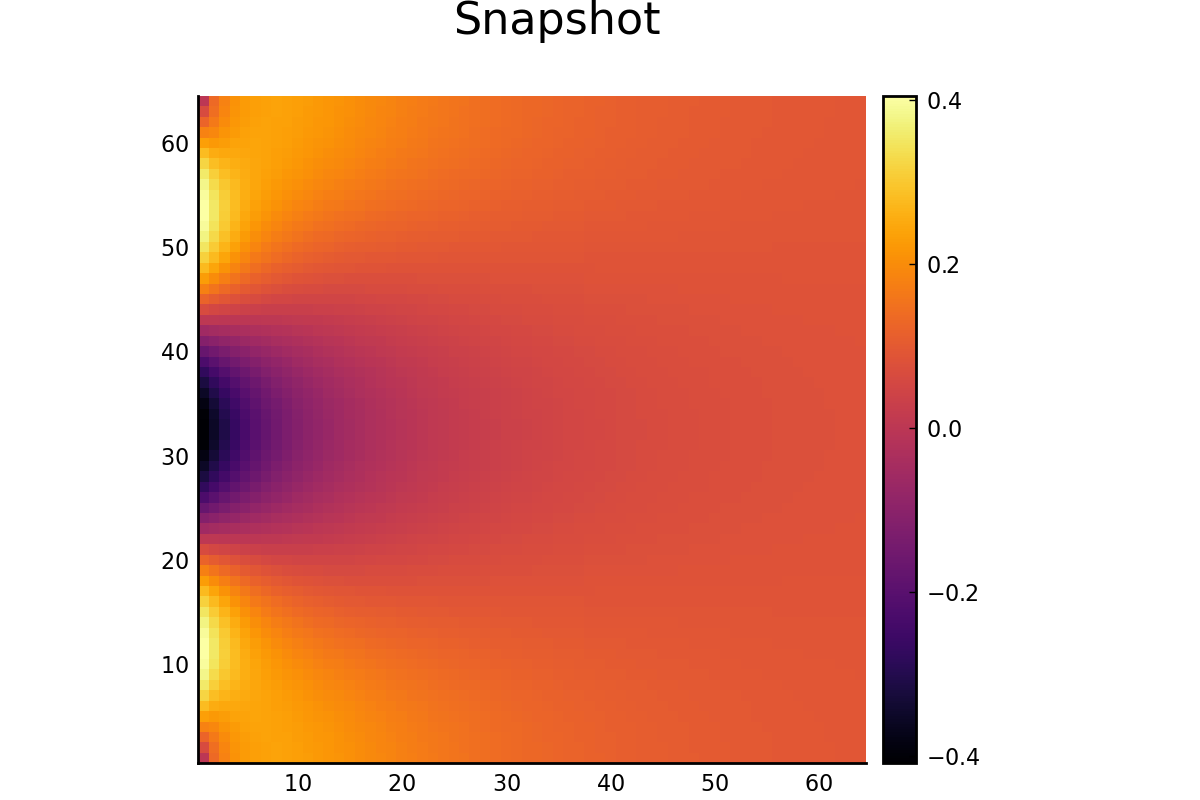

In [5]:
dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);

u0 = InitialFunctions.heat_analytical_init(t, x, n, c);
t, u = Equations.get_heat_fft(t, dx, x_n, 0.1, u0[1, :]);
GraphicTools.show_state(u, "Snapshot") # need to reverse u, odesolver switch dimensions

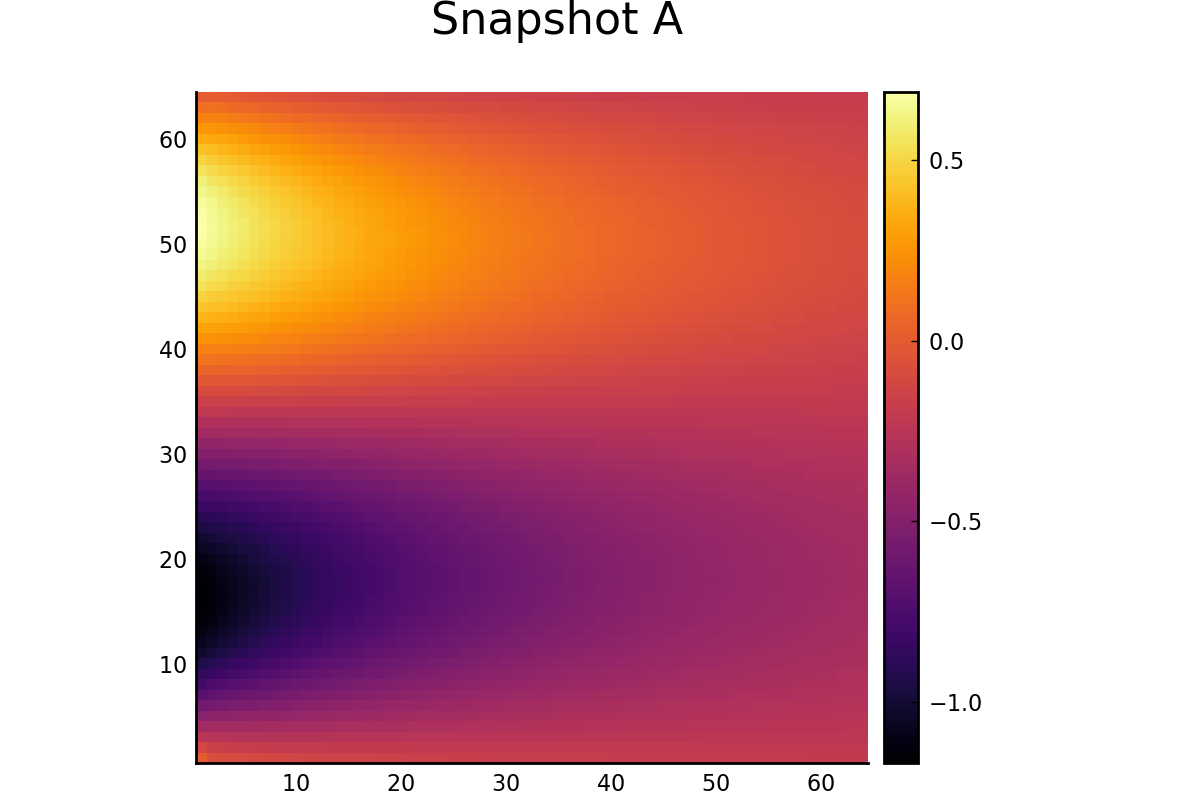

In [21]:
ta, u_a = Generator.heat_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, 3, 0.05, 1.);
GraphicTools.show_state(u_a, "Snapshot A")

## Training

In [32]:
dataset = Generator.generate_heat_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, 1, 32, 0.05, 1.)

Item1

LoadError: KeyError: key 32 not found

In [9]:
function HeatModel(x_n)
  return FastChain((x, p) ->
    FastDense(x_n,
      x_n,
      activation=identity,
      initW = Flux.glorot_uniform,
      initb = Flux.zeros32
    )
  )
end

HeatModel (generic function with 1 method)

In [10]:
function mseloss(u_pred, u_true)
  return sum(abs2, u_pred .- u_true) / prod(size(u_true))
end

mseloss (generic function with 1 method)

In [ ]:
function f(u, K, t)
  return K * u
end

In [ ]:
function S(net, u0, u_true, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(net), copy(u0), tspan)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

In [ ]:
function process_dataset(dataset)
  # todo - split between training and validation data
  init_set = []
  true_set = []
  for i in range(1, size(dataset, 1), step=1)
    t, u, _, _ = dataset[i]
    u0 = u[1, :]
    push!(init_set, u0)
    push!(true_set, u)
  end

  return t, init_set, true_set
end

In [ ]:
function callback(theta, loss, u_pred)
  display(loss)
  pl = scatter(t, dataset[1,:], label = "data")
end

In [ ]:
function heat_training(net, epochs, dataset)
  optimizer = DiffEqFlux.ADAM(0.01, (0.9, 0.999), 1.0e-8)
  t, u0, u_true = process_dataset(dataset)

  tspan = (t[1], t[end])
  neural_ode = NeuralODE(net, tspan, Tsit5(), saveat=t)

  function predict_neural_ode(theta)
    return Array(neural_ode(u0, theta))
  end

  function loss(theta)
    u_pred = predict_neural_ode(theta)
    l = Objectives.mseloss(u_pred, u_true)
    return l, u_pred
  end

  result = DiffEqFlux.sciml_train(loss, neural_ode.p, optimizer; cb = callback, maxiters = epochs)
end